In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile

import tensorflow as tf

import matplotlib.pyplot as plt

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,AvgPool2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

2023-12-19 10:17:20.749654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 10:17:20.749718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 10:17:20.750573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 10:17:20.756740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 10:17:21.418396: W tensorflow/compiler/tf2

In [2]:
combined_faces_zip_path = "./inputs/UTKFace.zip"
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall("./content/")
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [3]:
files_path = "./content/UTKFace"
pixels = []
age = []
gender = [] 

i=0
for img in os.listdir(files_path):
  i=i+1
  genders = img.split("_")[1]
  img = cv2.imread(str(files_path)+"/"+str(img))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img=cv2.resize(img,(100,100))
  pixels.append(np.array(img))
  gender.append(np.array(genders))

pixels = np.array(pixels)
gender = np.array(gender,np.uint64)

In [4]:
len(pixels)


23708

In [5]:
len(gender)

23708

In [6]:
x_train,x_test,y_train,y_test = train_test_split(pixels,gender,random_state=100)

In [7]:
len(x_train)


17781

In [8]:
len(x_test)

5927

In [13]:
input = Input(shape = (100,100,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(2,activation="sigmoid")(drop_1)

final_cnn = Model(inputs = input,outputs = output)
final_cnn.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy'])
final_cnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 dropout_5 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 activation_4 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [14]:

tensorboard = TensorBoard(log_dir=f"./outputs/gender/cnn_logs")

In [15]:

checkpoint = ModelCheckpoint(filepath=f"./outputs/gender/cnn_logs/age_model_checkpoint.h5",
                                            monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')

In [16]:
final_cnn_history = final_cnn.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=30,callbacks=[tensorboard,checkpoint])

Epoch 1/30


2023-12-19 10:20:43.665228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-19 10:20:44.369012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-19 10:20:46.793834: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f98787502c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 10:20:46.793881: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-12-19 10:20:46.818765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702960546.954493    3465 device_compiler.h:186] Compiled cluster using XL

556/556 [==============================] - ETA: 0s - loss: 1.2779 - accuracy: 0.7411
Epoch 1: loss improved from inf to 1.27792, saving model to ./outputs/gender/cnn_logs/age_model_checkpoint.h5
556/556 [==============================] - 18s 21ms/step - loss: 1.2779 - accuracy: 0.7411 - val_loss: 0.5509 - val_accuracy: 0.8495
Epoch 2/30
  8/556 [..............................] - ETA: 9s - loss: 0.4697 - accuracy: 0.8672

/home/bilson/projects/gender-age/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


553/556 [============================>.] - ETA: 0s - loss: 0.5050 - accuracy: 0.8487
Epoch 2: loss improved from 1.27792 to 0.50448, saving model to ./outputs/gender/cnn_logs/age_model_checkpoint.h5
556/556 [==============================] - 10s 17ms/step - loss: 0.5045 - accuracy: 0.8489 - val_loss: 0.4743 - val_accuracy: 0.8569
Epoch 3/30
555/556 [============================>.] - ETA: 0s - loss: 0.4478 - accuracy: 0.8639
Epoch 3: loss improved from 0.50448 to 0.44768, saving model to ./outputs/gender/cnn_logs/age_model_checkpoint.h5
556/556 [==============================] - 9s 17ms/step - loss: 0.4477 - accuracy: 0.8639 - val_loss: 0.4219 - val_accuracy: 0.8760
Epoch 4/30
554/556 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8770
Epoch 4: loss improved from 0.44768 to 0.40942, saving model to ./outputs/gender/cnn_logs/age_model_checkpoint.h5
556/556 [==============================] - 9s 17ms/step - loss: 0.4094 - accuracy: 0.8771 - val_loss: 0.4378 - val_a

In [17]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

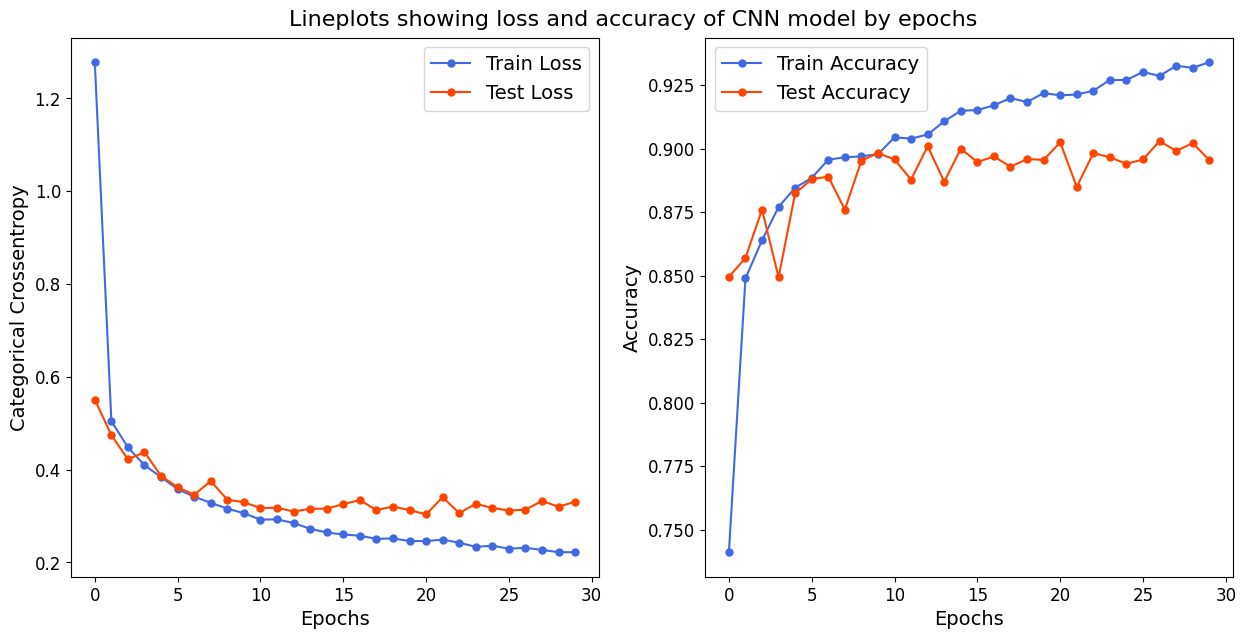

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

In [20]:
final_cnn.save("./gender_saved_model/", save_format='tf')


INFO:tensorflow:Assets written to: ./gender_saved_model/assets


INFO:tensorflow:Assets written to: ./gender_saved_model/assets
